In [3]:
# pip install torch===1.4.0 torchvision===0.5.0 -f https://download.pytorch.org/whl/torch_stable.html
# pip install facenet_pytorch

In [1]:
import os
import torch
import torchvision
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as tt
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline
import time
from torch.autograd import Variable
import pandas as pd
from PIL import Image
import random
from matplotlib import image
import shutil
from sklearn.model_selection import train_test_split
import cv2
from facenet_pytorch import MTCNN
from IPython import display
from sklearn.metrics import accuracy_score

In [2]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [6]:
class Hand_Classifier(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.conv1 = self.conv_block(1, 32, pool=False)
        self.conv2 = self.conv_block(32, 32, pool=True)
        self.conv3 = self.conv_block(32, 64, pool=True)
        self.drop = nn.Dropout(0.3)
        self.dense = nn.Sequential(nn.Flatten(), 
                                   nn.Linear(64*6*6, 256), 
                                   nn.ReLU(inplace=True), 
                                   nn.Linear(256, 10), 
                                   nn.Softmax(dim=1)
                                  )
        
    @staticmethod
    def conv_block(in_feat, out_feat, pool=False):
        layers = [nn.Conv2d(in_feat, out_feat, kernel_size=3), nn.ReLU(inplace=True)]
        if pool:
            layers.append(nn.MaxPool2d(kernel_size=3))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.drop(out)
        out = self.conv3(out)
        out = self.drop(out)
        out = self.dense(out)
        
        return out

In [7]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
device = get_default_device()
device

device(type='cpu')

In [8]:
def accuracy(pred, true):
    pred = np.argmax(pred.to('cpu').detach().numpy(), axis=1)
    true = true.to('cpu').detach().numpy()
    return len(np.where(pred==true)[0])/len(true)

In [9]:
hс = Hand_Classifier()

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(hс.parameters(), lr=0.001, weight_decay=1e-6)

In [11]:
hс.to(device)

Hand_Classifier(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (drop): Dropout(p=0.3, inplace=False)
  (dense): Sequential(
    (0): Flatten()
    (1): Linear(in_features=2304, out_features=256, bias=True)
    (2): ReLU(inplace=True)
    (3): Linear(in_features=256, out_features=10, bias=True)
    (4): Softmax(dim=1)
  )
)

In [14]:
savePATH = './hw5-hc.pth'
hс.load_state_dict(torch.load(savePATH, map_location=torch.device('cpu')))

<All keys matched successfully>

Face detected
palm


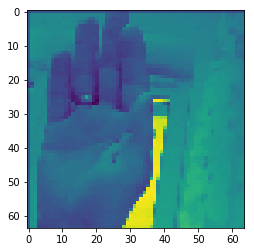

In [ ]:
import cv2
import torch
import numpy as np
from facenet_pytorch import MTCNN

mtcnn = MTCNN()

def _draw(frame, boxes):
    try:
        for box in boxes:
            # Рисуем обрамляющий прямоугольник лица на кадре
            cv2.rectangle(frame,
                          (box[0], box[1]),
                          (box[2], box[3]),
                          (0, 0, 255),
                          thickness=2)
    except:
        print('Something wrong im draw function!')
    return frame

def digit_to_classname(digit):
    if digit == 0:
        return 'palm'
    elif digit == 1:
        return 'l'
    elif digit == 2:
        return 'fist'
    elif digit == 3:
        return 'fist_moved'
    elif digit == 4:
        return 'thumb'
    elif digit == 5:
        return 'index'
    elif digit == 6:
        return 'ok'
    elif digit == 7:
        return 'palm_moved'
    elif digit == 8:
        return 'c'
    elif digit == 9:
        return 'down'

def crop_faces(frame, boxes):
    faces = []
    for i, box in enumerate(boxes):
        faces.append(frame[int(box[1]):int(box[3]), 
            int(box[0]):int(box[2])])
    return faces
    
flag_face = "Face not detected"

while True:
    cap = cv2.VideoCapture(0) 
    ret, frame = cap.read() 
    
    boxes, probs, landmarks = mtcnn.detect(frame, landmarks=True)
    
    if np.all(boxes):
        # Рисуем на кадре
        frame = _draw(frame, boxes)
        flag_face = "Face detected"
    else:
        flag_face = 'Face not detected' 
        
    if flag_face == "Face detected":
    
        cv2.rectangle(frame, (0,0), (250, 250), (0, 0, 255), thickness=2)
        hand = crop_faces(frame, [[0,0, 250, 250]])[0]

        hand = cv2.resize(hand, (64, 64))
        hand = cv2.cvtColor(hand, cv2.COLOR_BGR2GRAY)    
        
        #th, dframe = cv2.threshold(hand, 0, 255)
        
        torch_hand = torch.from_numpy(hand).unsqueeze(0).to(device).float()
        #torch_hand = torch.from_numpy(dframe).unsqueeze(0).to(device).float()
        gesture_probs = hс(torch_hand[None, ...])
    
    
    cv2.imshow('Face Detection', frame) 
    
    display.clear_output(wait=False)    
    print(flag_face)    
    if flag_face == "Face detected":
        print(digit_to_classname(gesture_probs.argmax()))
        plt.imshow(torch.tensor(torch_hand.detach().cpu().numpy()[0,:,:]))    
    display.display(plt.gcf())
    
    
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
        
# Очищаем все объекты opencv, что мы создали
self.cap.release()
cv2.destroyAllWindows()

In [40]:
cap.release()
cv2.destroyAllWindows()























